In [3]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import plotly.express as px


In [4]:
total_viviendas = 33_162_148

In [5]:
f = '../data/001_raw/ENCEVI_2018/vivienda.csv'
entidad = pd.read_csv(f,usecols=['folio','entidad'],index_col=0)

In [6]:
f ="../data/002_intermediate/vivienda_sin_aa.parquet"
viv =pd.read_parquet(f)
viv.factor.sum()
viv = viv.join(entidad,how='inner')
viv = viv[viv['entidad']==26]
del viv['entidad']
viv

,clima,factor,personas,m2,estrato,kwh_mes,kwh_m2,kwh_persona,kwh_m2persona
folio,,,,,,,,,
22590,Cálido extremoso,866,2,100.0,Medio alto,248.353667,5.215427,260.771350,2.607713
22599,Cálido extremoso,1071,4,55.0,Medio bajo,99.431435,1.868106,25.686454,0.467026
22601,Cálido extremoso,1071,2,100.0,Medio bajo,39.861273,0.810513,40.525628,0.405256
22628,Cálido extremoso,901,3,55.0,Medio bajo,118.996569,4.615625,84.619783,1.538542
22691,Cálido extremoso,996,1,30.0,Medio alto,683.033608,44.776648,1343.299429,44.776648
...,...,...,...,...,...,...,...,...,...
23432,Cálido extremoso,876,4,100.0,Medio bajo,36.586415,0.756119,18.902981,0.189030
23439,Cálido extremoso,795,2,75.0,Medio bajo,270.990191,3.733643,140.011599,1.866821
23440,Cálido extremoso,795,6,75.0,Medio bajo,27.199863,0.713241,8.915511,0.118873


In [7]:
viv.factor.sum()

np.int64(74473)

In [5]:

# --- 1) Función para calcular cuantiles ponderados ---
def cuantil_ponderado(valores, percentiles, pesos):
    v = np.array(valores)
    w = np.array(pesos)
    orden = np.argsort(v)
    v_ord, w_ord = v[orden], w[orden]
    cumw = np.cumsum(w_ord)
    cumw_norm = cumw / cumw[-1]
    return np.interp(percentiles, cumw_norm, v_ord)

# --- 2) Estadísticos ponderados sobre kwh_mes ---
def estadisticas_kwh_mes(df):
    vals = df['kwh_mes'].values
    wts  = df['factor'].values
    return pd.Series({
        'P25':     cuantil_ponderado(vals, [0.25], wts)[0],
        'Mediana': cuantil_ponderado(vals, [0.50], wts)[0],
        'Media':   np.average(vals, weights=wts),
        'P75':     cuantil_ponderado(vals, [0.75], wts)[0]
    })


# --- 2) Estadísticos ponderados sobre kwh_mes ---
def estadisticas_kwh_mes_persona(df):
    vals = df['kwh_persona'].values
    wts  = df['factor'].values
    return pd.Series({
        'P25':     cuantil_ponderado(vals, [0.25], wts)[0],
        'Mediana': cuantil_ponderado(vals, [0.50], wts)[0],
        'Media':   np.average(vals, weights=wts),
        'P75':     cuantil_ponderado(vals, [0.75], wts)[0]
    })
# --- 2) Estadísticos ponderados sobre kwh_mes ---
def estadisticas_kwh_mes_persona_area(df):
    vals = df['kwh_m2persona'].values
    wts  = df['factor'].values
    return pd.Series({
        'P25':     cuantil_ponderado(vals, [0.25], wts)[0],
        'Mediana': cuantil_ponderado(vals, [0.50], wts)[0],
        'Media':   np.average(vals, weights=wts),
        'P75':     cuantil_ponderado(vals, [0.75], wts)[0]
    })

In [6]:
f = "../data/002_intermediate/porcentajes_naa.parquet"
porcentajes_naa = pd.read_parquet(f)

In [7]:

# --- 3) Filtrado inicial ---
tamanos  = [30, 55, 75, 100, 150, 200]
estratos = ['Bajo', 'Medio bajo', 'Medio alto', 'Alto']

viv_tab = viv[viv['m2'].isin(tamanos)].copy()

# --- 4) Agrupar y calcular estadísticas ---
grouped = (
    viv_tab
    .groupby(['m2','clima','estrato'], observed=True)
    .apply(estadisticas_kwh_mes)
    .reset_index()
)
grouped =  pd.concat([grouped,porcentajes_naa[["porcentaje","viviendas"]]],axis=1)
grouped_kwhmes = grouped.copy()

# --- 5) Generar tablas Markdown ---
for clima in grouped['clima'].unique():
    for estrato in estratos:
        sub = grouped[
            (grouped['clima']==clima) &
            (grouped['estrato']==estrato)
        ]
        if sub.empty:
            continue

        # 6) Pivot: m2 en filas, percentiles en columnas en el orden correcto
        tabla = (
            sub
            .set_index('m2')[['P25','Mediana','Media','P75',"porcentaje"]]
            .reindex(tamanos)
            .rename_axis('m²')
            .round(2)
            .reset_index()
        )

        # 7) Generar slug y etiqueta Quarto
        slug_clima   = clima.lower().replace(' ','-').replace('í','i').replace('á','a')
        slug_estrato = estrato.lower().replace(' ','-')
        etiqueta     = f"tbl-{slug_clima}-{slug_estrato}"

        # 8) Imprimir en Markdown
        print(tabulate(
            tabla,
            headers=tabla.columns,
            tablefmt='pipe',
            floatfmt='.2f',
            showindex=False
        ))
        print(
            f": Estadísticas ponderadas de consumo total mensual (KWh) para clima **{clima}**, "
            f"estrato socioeconómico **{estrato}** {{#{etiqueta}}}\n"
        )

|     m² |    P25 |   Mediana |   Media |    P75 |   porcentaje |
|-------:|-------:|----------:|--------:|-------:|-------------:|
|  30.00 | nan    |    nan    |  nan    | nan    |       nan    |
|  55.00 |  50.42 |     50.42 |   78.25 |  71.24 |         0.52 |
|  75.00 | nan    |    nan    |  nan    | nan    |       nan    |
| 100.00 | 105.78 |    105.78 |  105.78 | 105.78 |         1.35 |
| 150.00 | nan    |    nan    |  nan    | nan    |       nan    |
| 200.00 | nan    |    nan    |  nan    | nan    |       nan    |
: Estadísticas ponderadas de consumo total mensual (KWh) para clima **Cálido extremoso**, estrato socioeconómico **Bajo** {#tbl-calido-extremoso-bajo}

|     m² |   P25 |   Mediana |   Media |    P75 |   porcentaje |
|-------:|------:|----------:|--------:|-------:|-------------:|
|  30.00 | 30.87 |    116.15 |  180.92 | 252.33 |         0.11 |
|  55.00 | 45.06 |     98.33 |  169.00 | 188.15 |         1.01 |
|  75.00 | 35.58 |     63.12 |  106.96 | 109.88 |         2.

/var/folders/tc/1tpm30d53_9458mzx73ydg_w0000gn/T/ipykernel_4419/2426823092.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(estadisticas_kwh_mes)


In [8]:

# --- 3) Filtrado inicial ---
tamanos  = [30, 55, 75, 100, 150, 200]
estratos = ['Bajo', 'Medio bajo', 'Medio alto', 'Alto']

viv_tab = viv[viv['m2'].isin(tamanos)].copy()

# --- 4) Agrupar y calcular estadísticas ---
grouped = (
    viv_tab
    .groupby(['m2','clima','estrato'], observed=True)
    .apply(estadisticas_kwh_mes_persona)
    .reset_index()
)


grouped =  pd.concat([grouped,porcentajes_naa[["porcentaje","viviendas"]]],axis=1)
grouped_kwhmespersona = grouped.copy()

# --- 5) Generar tablas Markdown ---
for clima in grouped['clima'].unique():
    for estrato in estratos:
        sub = grouped[
            (grouped['clima']==clima) &
            (grouped['estrato']==estrato)
        ]
        if sub.empty:
            continue

        # 6) Pivot: m2 en filas, percentiles en columnas en el orden correcto
        tabla = (
            sub
            .set_index('m2')[['P25','Mediana','Media','P75']]
            .reindex(tamanos)
            .rename_axis('m²')
            .round(2)
            .reset_index()
        )

        # 7) Generar slug y etiqueta Quarto
        slug_clima   = clima.lower().replace(' ','-').replace('í','i').replace('á','a')
        slug_estrato = estrato.lower().replace(' ','-')
        etiqueta     = f"tbl-{slug_clima}-{slug_estrato}"

        # 8) Imprimir en Markdown
        print(tabulate(
            tabla,
            headers=tabla.columns,
            tablefmt='pipe',
            floatfmt='.2f',
            showindex=False
        ))
        print(
            f": Estadísticas ponderadas de consumo total mensual (KWh) para clima **{clima}**, "
            f"estrato socioeconómico **{estrato}** {{#{etiqueta}}}\n"
        )

|     m² |    P25 |   Mediana |   Media |    P75 |
|-------:|-------:|----------:|--------:|-------:|
|  30.00 | nan    |    nan    |  nan    | nan    |
|  55.00 |  38.92 |     55.27 |   82.47 |  79.74 |
|  75.00 | nan    |    nan    |  nan    | nan    |
| 100.00 |  53.77 |     53.77 |   53.77 |  53.77 |
| 150.00 | nan    |    nan    |  nan    | nan    |
| 200.00 | nan    |    nan    |  nan    | nan    |
: Estadísticas ponderadas de consumo total mensual (KWh) para clima **Cálido extremoso**, estrato socioeconómico **Bajo** {#tbl-calido-extremoso-bajo}

|     m² |   P25 |   Mediana |   Media |    P75 |
|-------:|------:|----------:|--------:|-------:|
|  30.00 | 62.77 |     84.65 |  157.09 | 153.80 |
|  55.00 | 37.77 |     84.83 |  146.16 | 103.99 |
|  75.00 | 28.33 |     38.12 |   57.31 |  73.44 |
| 100.00 | 29.49 |     39.01 |   81.14 |  68.03 |
| 150.00 | 45.63 |     52.46 |   71.73 |  77.94 |
| 200.00 | 43.54 |     43.54 |   92.95 |  92.46 |
: Estadísticas ponderadas de consumo tot

/var/folders/tc/1tpm30d53_9458mzx73ydg_w0000gn/T/ipykernel_4419/137336241.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(estadisticas_kwh_mes_persona)


In [9]:

# --- 3) Filtrado inicial ---
tamanos  = [30, 55, 75, 100, 150, 200]
estratos = ['Bajo', 'Medio bajo', 'Medio alto', 'Alto']

viv_tab = viv[viv['m2'].isin(tamanos)].copy()

# --- 4) Agrupar y calcular estadísticas ---
grouped = (
    viv_tab
    .groupby(['m2','clima','estrato'], observed=True)
    .apply(estadisticas_kwh_mes_persona_area)
    .reset_index()
)


grouped =  pd.concat([grouped,porcentajes_naa[["porcentaje","viviendas"]]],axis=1)
grouped_kwhmespersonaarea = grouped.copy()

# --- 5) Generar tablas Markdown ---
for clima in grouped['clima'].unique():
    for estrato in estratos:
        sub = grouped[
            (grouped['clima']==clima) &
            (grouped['estrato']==estrato)
        ]
        if sub.empty:
            continue

        # 6) Pivot: m2 en filas, percentiles en columnas en el orden correcto
        tabla = (
            sub
            .set_index('m2')[['P25','Mediana','Media','P75']]
            .reindex(tamanos)
            .rename_axis('m²')
            .round(2)
            .reset_index()
        )

        # 7) Generar slug y etiqueta Quarto
        slug_clima   = clima.lower().replace(' ','-').replace('í','i').replace('á','a')
        slug_estrato = estrato.lower().replace(' ','-')
        etiqueta     = f"tbl-{slug_clima}-{slug_estrato}"

        # 8) Imprimir en Markdown
        print(tabulate(
            tabla,
            headers=tabla.columns,
            tablefmt='pipe',
            floatfmt='.2f',
            showindex=False
        ))
        print(
            f": Estadísticas ponderadas de consumo total mensual (KWh) para clima **{clima}**, "
            f"estrato socioeconómico **{estrato}** {{#{etiqueta}}}\n"
        )

|     m² |    P25 |   Mediana |   Media |    P75 |
|-------:|-------:|----------:|--------:|-------:|
|  30.00 | nan    |    nan    |  nan    | nan    |
|  55.00 |   0.71 |      1.00 |    1.50 |   1.45 |
|  75.00 | nan    |    nan    |  nan    | nan    |
| 100.00 |   0.54 |      0.54 |    0.54 |   0.54 |
| 150.00 | nan    |    nan    |  nan    | nan    |
| 200.00 | nan    |    nan    |  nan    | nan    |
: Estadísticas ponderadas de consumo total mensual (KWh) para clima **Cálido extremoso**, estrato socioeconómico **Bajo** {#tbl-calido-extremoso-bajo}

|     m² |   P25 |   Mediana |   Media |   P75 |
|-------:|------:|----------:|--------:|------:|
|  30.00 |  2.09 |      2.82 |    5.24 |  5.13 |
|  55.00 |  0.69 |      1.54 |    2.66 |  1.89 |
|  75.00 |  0.38 |      0.51 |    0.76 |  0.98 |
| 100.00 |  0.29 |      0.39 |    0.81 |  0.68 |
| 150.00 |  0.30 |      0.35 |    0.48 |  0.52 |
| 200.00 |  0.22 |      0.22 |    0.46 |  0.46 |
: Estadísticas ponderadas de consumo total mensu

/var/folders/tc/1tpm30d53_9458mzx73ydg_w0000gn/T/ipykernel_4419/2581412135.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(estadisticas_kwh_mes_persona_area)


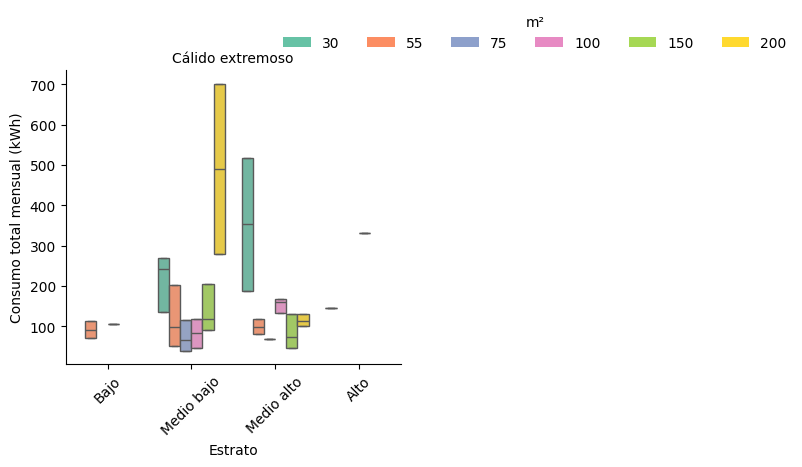

In [10]:
#| label: fig-total
#| fig-cap: Consumo total mensual de la vivienda para los diferentes climas y estratos socioeconómicos y sin uso de aire acondicionado.
estrato_order = ['Bajo', 'Medio bajo', 'Medio alto', 'Alto']
m2_list = sorted(viv['m2'].unique())

# 2) Crea tu palette y un dict m2→color
colors = sns.color_palette('Set2', n_colors=len(m2_list))
palette_dict = {m2: colors[i] for i, m2 in enumerate(m2_list)}

# 3) Dibuja el catplot SIN leyenda
g = sns.catplot(
    data=viv,
    x='estrato',
    y='kwh_mes',
    hue='m2',
    palette=palette_dict,
    col='clima',
    kind='box',
    order=estrato_order,
    col_wrap=3,
    height=4,
    sharey=True,
    whis=[25,75],
    showfliers=False,
    legend=False      # importante: no leyenda automática
)

# 4) Formatea ejes y títulos
g.set_axis_labels("Estrato", "Consumo total mensual (kWh)")
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)

# 5) Construye los patches manualmente
patches = [
    Patch(facecolor=palette_dict[m], label=str(int(m)))
    for m in m2_list
]

# 6) Añade la leyenda centrada un poco a la izquierda
g.fig.legend(
    handles=patches,
    title="m²",
    loc="upper center",
    bbox_to_anchor=(0.45, 1.05),  # ajusta este 0.45 para moverla más a la izquierda/derecha
    ncol=len(m2_list),
    frameon=False
)

# 7) Ajusta márgenes
g.fig.subplots_adjust(top=0.88, right=0.92)

plt.show()


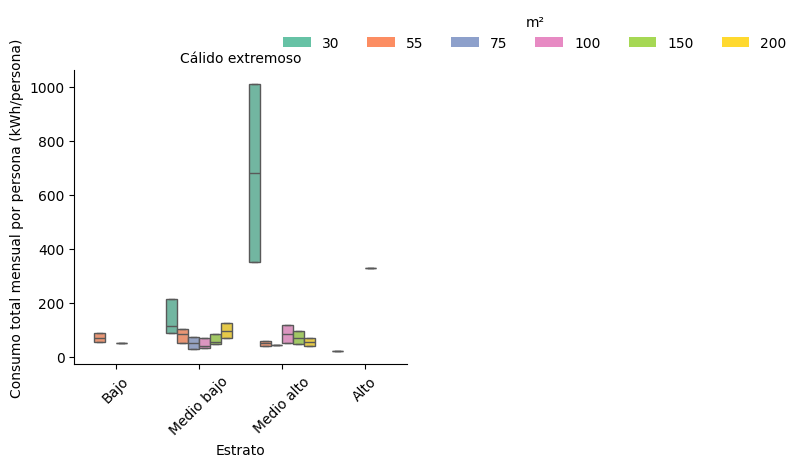

In [11]:
#| label: fig-total
#| fig-cap: Consumo total mensual de la vivienda para los diferentes climas y estratos socioeconómicos y sin uso de aire acondicionado.
estrato_order = ['Bajo', 'Medio bajo', 'Medio alto', 'Alto']
m2_list = sorted(viv['m2'].unique())

# 2) Crea tu palette y un dict m2→color
colors = sns.color_palette('Set2', n_colors=len(m2_list))
palette_dict = {m2: colors[i] for i, m2 in enumerate(m2_list)}

# 3) Dibuja el catplot SIN leyenda
g = sns.catplot(
    data=viv,
    x='estrato',
    y='kwh_persona',
    hue='m2',
    palette=palette_dict,
    col='clima',
    kind='box',
    order=estrato_order,
    col_wrap=3,
    height=4,
    sharey=True,
    whis=[25,75],
    showfliers=False,
    legend=False      # importante: no leyenda automática
)

# 4) Formatea ejes y títulos
g.set_axis_labels("Estrato", "Consumo total mensual por persona (kWh/persona)")
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)

# 5) Construye los patches manualmente
patches = [
    Patch(facecolor=palette_dict[m], label=str(int(m)))
    for m in m2_list
]

# 6) Añade la leyenda centrada un poco a la izquierda
g.fig.legend(
    handles=patches,
    title="m²",
    loc="upper center",
    bbox_to_anchor=(0.45, 1.05),  # ajusta este 0.45 para moverla más a la izquierda/derecha
    ncol=len(m2_list),
    frameon=False
)

# 7) Ajusta márgenes
g.fig.subplots_adjust(top=0.88, right=0.92)

plt.show()


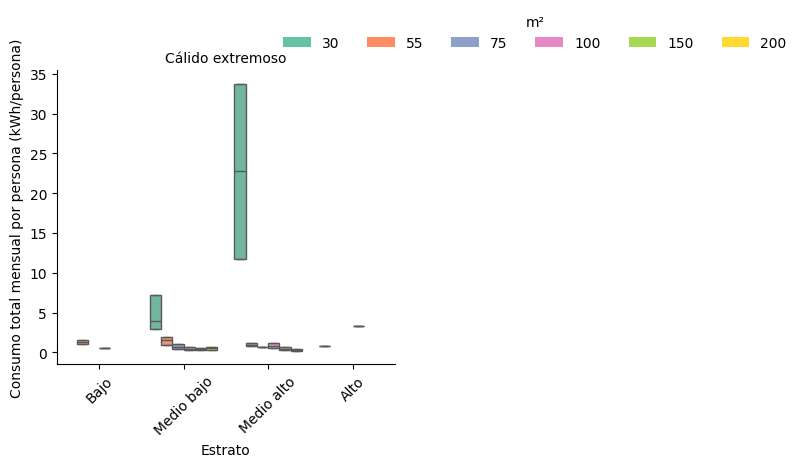

In [12]:
#| label: fig-total
#| fig-cap: Consumo total mensual de la vivienda para los diferentes climas y estratos socioeconómicos y sin uso de aire acondicionado.
estrato_order = ['Bajo', 'Medio bajo', 'Medio alto', 'Alto']
m2_list = sorted(viv['m2'].unique())

# 2) Crea tu palette y un dict m2→color
colors = sns.color_palette('Set2', n_colors=len(m2_list))
palette_dict = {m2: colors[i] for i, m2 in enumerate(m2_list)}

# 3) Dibuja el catplot SIN leyenda
g = sns.catplot(
    data=viv,
    x='estrato',
    y='kwh_m2persona',
    hue='m2',
    palette=palette_dict,
    col='clima',
    kind='box',
    order=estrato_order,
    col_wrap=3,
    height=4,
    sharey=True,
    whis=[25,75],
    showfliers=False,
    legend=False      # importante: no leyenda automática
)

# 4) Formatea ejes y títulos
g.set_axis_labels("Estrato", "Consumo total mensual por persona (kWh/persona)")
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)

# 5) Construye los patches manualmente
patches = [
    Patch(facecolor=palette_dict[m], label=str(int(m)))
    for m in m2_list
]

# 6) Añade la leyenda centrada un poco a la izquierda
g.fig.legend(
    handles=patches,
    title="m²",
    loc="upper center",
    bbox_to_anchor=(0.45, 1.05),  # ajusta este 0.45 para moverla más a la izquierda/derecha
    ncol=len(m2_list),
    frameon=False
)

# 7) Ajusta márgenes
g.fig.subplots_adjust(top=0.88, right=0.92)

plt.show()


In [13]:
grouped_kwhmes["etotal"] = grouped_kwhmes.Media*grouped_kwhmes.viviendas
grouped_kwhmes.sort_values(by="etotal",ascending=False)

,m2,clima,estrato,P25,Mediana,Media,P75,porcentaje,viviendas,etotal
15,200.0,Cálido extremoso,Medio bajo,68.743118,68.743118,452.774187,448.986303,1.042562,345736.0,1.565403e+08
7,75.0,Cálido extremoso,Medio bajo,35.575006,63.124793,106.956038,109.879163,2.841960,942455.0,1.008013e+08
11,100.0,Cálido extremoso,Medio bajo,41.165181,66.807680,180.232915,104.389011,0.983977,326308.0,5.881144e+07
5,55.0,Cálido extremoso,Medio bajo,45.058011,98.328373,169.002358,188.154703,1.006820,333883.0,5.642701e+07
9,100.0,Cálido extremoso,Bajo,105.784101,105.784101,105.784101,105.784101,1.347802,446960.0,4.728126e+07
...,...,...,...,...,...,...,...,...,...,...
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.915470,635211.0,NaN
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004716,1564.0,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.270070,89561.0,NaN
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042817,14199.0,NaN


In [14]:
# Opción 1: Seleccionar las 4 columnas tras ordenar
df_vis = (
    grouped_kwhmes
      .sort_values(by="etotal", ascending=False)
      [["m2","clima","estrato","viviendas","etotal"]]
      .reset_index(drop=True)
)
display(df_vis)


,m2,clima,estrato,viviendas,etotal
0,200.0,Cálido extremoso,Medio bajo,345736.0,1.565403e+08
1,75.0,Cálido extremoso,Medio bajo,942455.0,1.008013e+08
2,100.0,Cálido extremoso,Medio bajo,326308.0,5.881144e+07
3,55.0,Cálido extremoso,Medio bajo,333883.0,5.642701e+07
4,100.0,Cálido extremoso,Bajo,446960.0,4.728126e+07
...,...,...,...,...,...
67,NaN,NaN,NaN,635211.0,NaN
68,NaN,NaN,NaN,1564.0,NaN
69,NaN,NaN,NaN,89561.0,NaN
70,NaN,NaN,NaN,14199.0,NaN


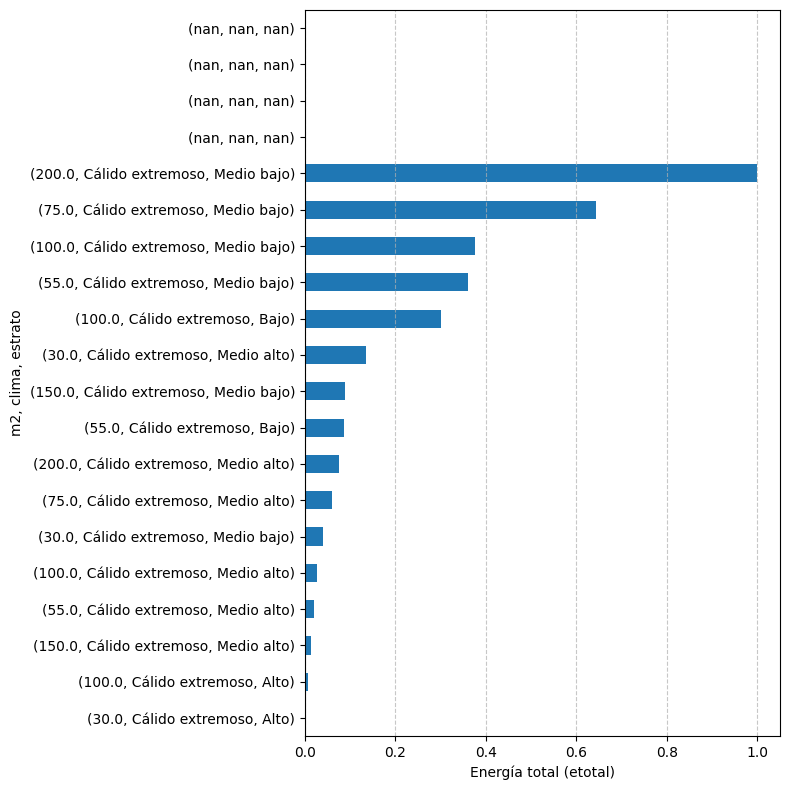

In [15]:

# Prepara Serie normalizada (ya la tienes)
et = (
    grouped_kwhmes
      .sort_values(by="etotal", ascending=False)
      .set_index(["m2","clima","estrato"])["etotal"]
      .head(20)
)
et = et / et.max()

# Grafica horizontal
plt.figure(figsize=(8, 8))
# Para que la barra más grande quede arriba, ordena de menor a mayor
et.sort_values().plot(kind='barh')

plt.xlabel("Energía total (etotal)")
plt.ylabel("m2, clima, estrato")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

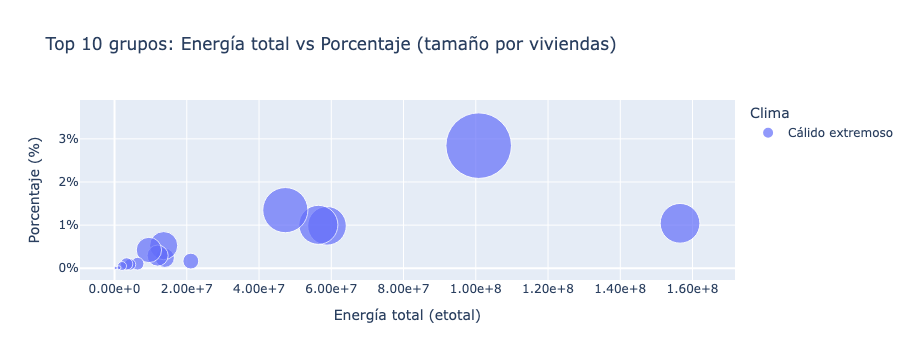

In [16]:

# Ordenar y seleccionar top 10 grupos por etotal
df_top10 = (
    grouped_kwhmes
    .sort_values(by='etotal', ascending=False)
    # .head(30)
    .reset_index()
)

# Crear gráfica de burbujas: etotal vs porcentaje, tamaño por viviendas, color por clima
fig = px.scatter(
    df_top10,
    x='etotal',
    y='porcentaje',
    size='viviendas',
    color='clima',
    hover_data=['m2', 'estrato', 'viviendas', 'porcentaje', 'etotal'],
    labels={
        'etotal': 'Energía total (etotal)',
        'porcentaje': 'Porcentaje (%)',
        'viviendas': 'Número de viviendas',
        'clima': 'Clima'
    },
    title='Top 10 grupos: Energía total vs Porcentaje (tamaño por viviendas)',
    size_max=60
)

fig.update_layout(
    xaxis=dict(tickformat=".2e"),
    yaxis=dict(ticksuffix="%")
)

fig.show()


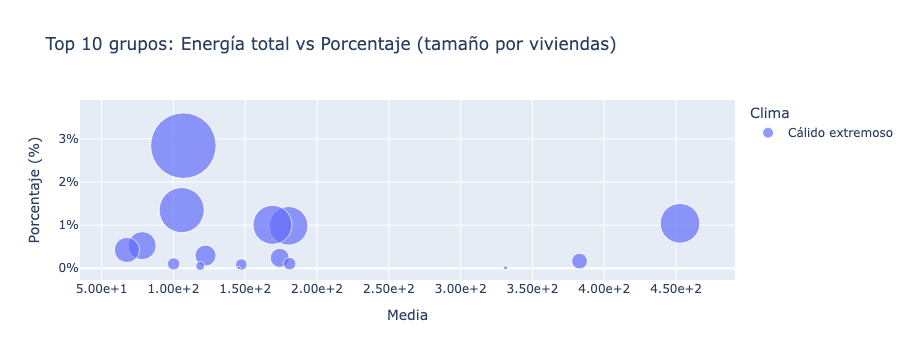

In [17]:

# Ordenar y seleccionar top 10 grupos por etotal
df_top10 = (
    grouped_kwhmes
    .sort_values(by='etotal', ascending=False)
    # .head(30)
    .reset_index()
)

# Crear gráfica de burbujas: etotal vs porcentaje, tamaño por viviendas, color por clima
fig = px.scatter(
    df_top10,
    x='Media',
    y='porcentaje',
    size='viviendas',
    color='clima',
    hover_data=['m2', 'estrato', 'viviendas', 'porcentaje', 'etotal'],
    labels={
        'etotal': 'Energía total (etotal)',
        'porcentaje': 'Porcentaje (%)',
        'viviendas': 'Número de viviendas',
        'clima': 'Clima'
    },
    title='Top 10 grupos: Energía total vs Porcentaje (tamaño por viviendas)',
    size_max=60
)

fig.update_layout(
    xaxis=dict(tickformat=".2e"),
    yaxis=dict(ticksuffix="%")
)

fig.show()
